In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy
import skimage
import csv

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
import imutils

In [2]:
RefPath = '/srv/home/chenyu/DEbackup/2019/062819/S0/'
RefName = 'S0'
# number of rows and columns for the scan grid
num_rows = 150
num_cols = 150

sample = np.load(RefPath+'npy/'+RefName+'_'+format(1,'05')+'.npy')
kx,ky = sample.shape[0:2]
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

COM = np.zeros((num_rows,num_cols,2))

for irow in range(num_rows):
    for icol in range(num_cols):
        nSample = irow*num_cols+icol+1
        sample = np.load(RefPath+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        COM[irow,icol,0] = np.average(weights_x,weights = sample)
        COM[irow,icol,1] = np.average(weights_y,weights = sample)
        
        if irow % 10 == 0 and icol == 0:
            print("Finished row %d " % (irow))
            
np.save('/srv/home/chenyu/DEbackup/2019/062819/BlankCOM.npy',COM)

Finished row 0 
Finished row 10 
Finished row 20 
Finished row 30 
Finished row 40 
Finished row 50 
Finished row 60 
Finished row 70 
Finished row 80 
Finished row 90 
Finished row 100 
Finished row 110 
Finished row 120 
Finished row 130 
Finished row 140 


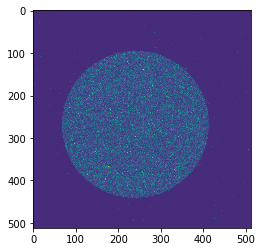

In [5]:
plt.imshow(sample)

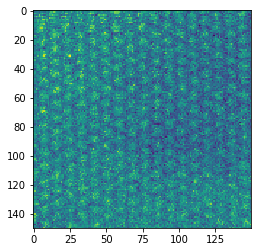

In [47]:
# load previous reconstucted blank COM map if it exist
ExpPath = '/srv/home/chenyu/DEbackup/2019/062819/S4/'
ExpName = 'S4'
rx = 150
ry = 150
COM = np.load('/srv/home/chenyu/DEbackup/2019/062819/BlankCOM.npy')

file_HAADF = [image for image in os.listdir(ExpPath) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(ExpPath +  file_HAADF) as csvfile:
    file=csv.reader(open(ExpPath+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))
plt.imshow(HAADFarray)

In [48]:
sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(1000,'05')+'.npy')
kx,ky = sample.shape[0:2]
PACBED = np.zeros((kx,ky))

kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
kx2,ky2 = np.meshgrid(kx,ky)

COM_exp = np.zeros((rx,ry,2))
COM_exp_ang = np.zeros((rx,ry))
BF = np.zeros((rx,ry))
ABF = np.zeros((rx,ry))
ADF = np.zeros((rx,ry))

# inner collection radius for ABF and outer collection radius for BF/ABF, replace with Hough detected radius later
ABF_radius = 87
BF_radius = 175
ADF_radius = 250

for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(ExpPath+'npy/'+ExpName+'_'+format(filenum,'05')+'.npy')
        COM_exp[ix,iy,0] = np.average(weights_x,weights = frame)
        COM_exp[ix,iy,1] = np.average(weights_y,weights = frame)
        COM_exp_ang[ix,iy] = math.atan2(COM_exp[ix,iy,0]-COM[ix,iy,0],COM_exp[ix,iy,1]-COM[ix,iy,1])
        
        center_x = COM[ix,iy,0]
        center_y = COM[ix,iy,1]
        distance_from_center = np.sqrt((kx2 - center_x)**2 + (ky2-center_y)**2)
        ADF_mask = (distance_from_center > BF_radius) & (distance_from_center <= ADF_radius)
        ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
        BF_mask = distance_from_center <= BF_radius
        
        BF[ix,iy] = (frame*BF_mask).sum()
        ABF[ix,iy] = (frame*ABF_mask).sum()
        ADF[ix,iy] = (frame*ADF_mask).sum()
        PACBED = PACBED + frame
        
COM_exp = COM_exp - COM
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)

np.save(ExpPath + 'ADF.npy',ADF)
np.save(ExpPath+'COM.npy',COM_exp)
np.save(ExpPath+'BF.npy',BF)
np.save(ExpPath+'ABF.npy',ABF)
np.save(ExpPath+'PACBED.npy',PACBED)

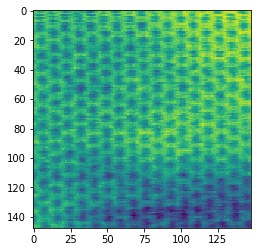

In [52]:
plt.imshow(BF[1:-1,1:-1])

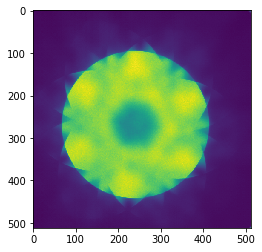

In [53]:
plt.imshow(PACBED)